# <center> Problématique 2 - Product Matching </center>

In [1]:
# Librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from product_categorization import *
from matrice_similarity import *
from preprocessing_ner import *
from preprocessing import *
from load_data import *
from embedding import *
from confusion_matrix import *

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, auc, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 100)

C:\Users\Pascal\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Partie I : Modele Product Matching

## 1. Chose Category Innoscape

In [2]:
# Choisir catégorie Innoscape, la liste des catégories se trouve dans Data/reference_innoscape.xlsx
category = 61

## 2. Save Model

### a) Load data

In [4]:
# Import données
df = load_data('../../Data/data_similary_products.csv')

### b) Preprocessing & NER

In [5]:
# Chargement liste marques, stop words pour le preprocessing
unique_brand = open('../../Data/unique_brand.txt').read().split('\n')
stop_words = load_txt("../../Data/stop_words.txt")
tag_dir = 'C:/TreeTagger'

In [6]:
# NER : Extraction des features
df = ner_preprocessing(df, 'productseller_name', 'brand_seller', unique_brand)

In [7]:
# Preprocessing description
df_description = preprocessing(df, ['Description'], stop_words, tag_dir)

In [10]:
# On garde les colonnes pertinentes
col = ['id_page',
       'label',
       'id_product',
       'productseller_name',
       'brand',
       'Description',
       'Volume',
       'Mesure',
       'Poids',
       'AmpereHeure',
       'NewtonMetre',
       'Watt',
       'Volt',
       'Rpm',
       'Joules',
       'Metre2',
       'Couleur',
       'product_price',
       'model',
       'Description_clean']

df = df[col]

### c) Save Embedding TF IDF / NMF

In [14]:
# Entrainement Embedding (TF-IDF + NMF)
# PAS BESOIN DE RUN SI MODELE DEJA ENTRAINE POUR LA CATEGORIE
embedding(df_description, '../../models/tfidf_max_vocab_base_2', '../../models/nmf_250topics_base_2', mode='save') 

### d) Matrix of distances

In [15]:
# Chargement embedding et transformation de la description dans l'espace d'embedding 
X_nmf, vocab = embedding(df_description, '../../models/tfidf_max_vocab_base_2', '../../models/nmf_250topics_base_2', mode='load') 

In [16]:
# On concat les dataframes des attributs + description transformée dans l'espace embedding
topics = ["topic_"+str(i+1) for i in range(250)]
df_topics = pd.DataFrame(X_nmf, columns=topics).set_index(df.index)
df_new = pd.concat((df, df_topics), axis=1)

In [17]:
# Construction matrice de distance
threshold_nan = 0.6
X, y, pair_id_page, pair_id_product = get_matrix_similarity(df_new, category, threshold_nan, topics, mode='training')
#X, pair_id_product = get_matrix_similarity(df, category, threshold_na, topics, mode='prediction', nb=1)


### e) Classification : Training

In [18]:
# Train/test set 
X_train, X_test, y_train, y_test, id_page_train, id_page_test = train_test_split(X, y, pair_id_page, test_size=0.2, stratify=y, random_state=2)


In [20]:
# Entrainement classifieur
# PAS BESOIN DE RUN SI MODELE DEJA ENTRAINE POUR LA CATEGORIE
categorization(X_train, y_train, mode='training', path='../../models/categorization_model_'+str(category), n_jobs=-1)


## 3. Prediction

In [22]:
# Predictions hard et soft classifieur
prediction, soft_proba = categorization(X_test, mode='prediction', thresholding='default', path='../../models/categorization_model_'+str(category))


In [23]:
# On affiche les résultats
result = pd.DataFrame()
result['test'] = y_test
result['predict'] = prediction
result['predict_proba_0'] = soft_proba[:,0]
result['predict_proba_1'] = soft_proba[:,1]
result['paire_id_page'] = id_page_test

result.head(10)#.sort_values('predict_proba_1', ascending=False)

test  predict  predict_proba_0  predict_proba_1  \
0     0        0              1.0              0.0   
1     0        0              1.0              0.0   
2     0        0              1.0              0.0   
3     0        0              1.0              0.0   
4     0        0              1.0              0.0   
5     0        0              1.0              0.0   
6     0        0              1.0              0.0   
7     0        0              1.0              0.0   
8     0        0              1.0              0.0   
9     0        0              1.0              0.0   

                                                                 paire_id_page  
0     /prix/3125018/bosch-pbh-2100-sre.html_/prix/4926524/ryobi-rsds680-k.html  
1          /prix/466496/makita-hm1400.html_/prix/6418485/ryobi-rpd2-1000k.html  
2          /prix/4780208/aeg-sb2e-850-r.html_/prix/4893712/dewalt-d25144k.html  
3        /prix/3974567/makita-hp2051fhj.html_/prix/4780208/aeg-sb2e-850-r.html  
4        /prix/2088422/dewalt-d25323k.html_/prix/6418485/ryobi-rpd2-1000k.html  
5          /prix/4893712/dewalt-d25144k.html_/prix/4780208/aeg-sb2e-850-r.html  
6       /prix/4893712/dewalt-d25144k.html_/prix/3847206/makita-hr2310tsp1.html  
7         /prix/4893712/dewalt-d25144k.html_/prix/4926524/ryobi-rsds680-k.html  
8  /prix/3125018/bosch-pbh-2100-sre.html_/prix/4819270/einhell-te-rh-32-e.html  
9      /prix/4893712/dewalt-d25144k.html_/prix/4819270/einhell-te-rh-32-e.html

C:\Users\Pascal\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


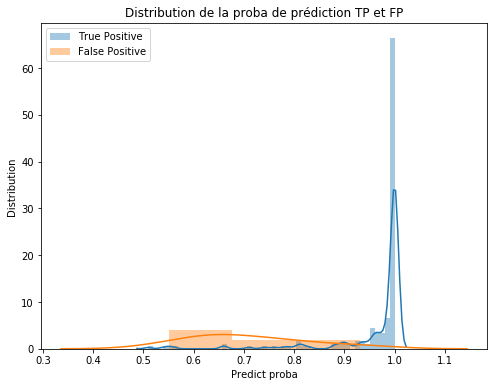

In [24]:
# Plot distribution proba de prédiction des "Vrais Positifs" et "Faux Positifs"
true_proba1 = result[(result['predict']==1)&(result['test']==1)]['predict_proba_1']
false_proba1 = result[(result['predict']==1)&(result['test']==0)]['predict_proba_1']
plt.figure(figsize=(8,6))
sns.distplot(true_proba1, label="True Positive")
sns.distplot(false_proba1, label="False Positive")
plt.legend()
plt.xlabel("Predict proba")
plt.ylabel("Distribution")
plt.title("Distribution de la proba de prédiction TP et FP")
plt.show()

## 4. Evaluation Metrics

In [25]:
# Evaluation
print("accuracy : ", round(accuracy_score(prediction, y_test),4), "\n")
print("recall : ", round(recall_score(prediction, y_test),4), "\n")
print("precision : ", round(precision_score(prediction, y_test),4), "\n")
print("f1_score : ", round(f1_score(prediction, y_test),4))

accuracy :  0.993 

recall :  0.9588 

precision :  0.9538 

f1_score :  0.9563


#### Matrice de confusion

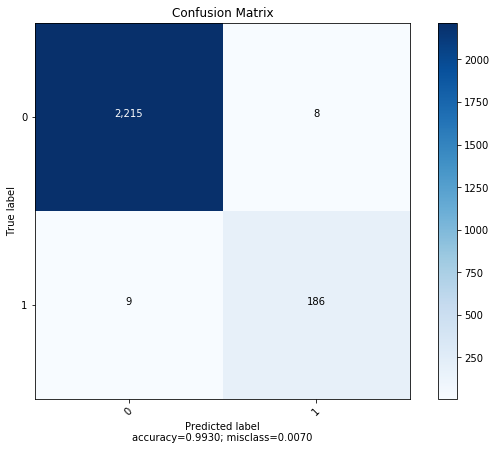

In [26]:
# Matrice de confusion
cnf_matrix = confusion_matrix(y_test, prediction)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, normalize = False, target_names = ['0', '1'], title="Confusion Matrix")

#### Courbe ROC

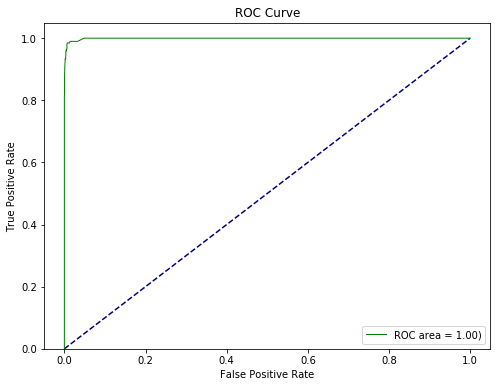

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, soft_proba[:,1])
roc_auc = auc(fpr, tpr)

# Courbe ROC 
plt.figure(figsize=(8,6))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.plot(fpr, tpr, color='green', lw=1, label='ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

# Partie II : Demo pour un nouveau produit

In [34]:
# Démonstration identification nouveau produit

# Choix catégorie
category = 61

# On charge le fichier csv contenant les produits de la base de données 
# déjà preprocessé et description dans l'espace d'embedding sans id_page
df = pd.read_csv('../../Data/data_similary_products_computed.csv')
df = df.iloc[1:,:]
list_cat = ['Couleur', 'model', 'brand']
for cat in list_cat:
    df[cat].fillna('', inplace=True)
df['id_product'] = df['id_product'].apply(lambda x: str(x))
    
# Dictionnaire de correspondance : id produit --> produit
df_ref = load_data('../../Data/data_similary_products.csv.csv')
id_to_product = df_ref[['id_product', 'id_page']]
id_to_product = id_to_product.set_index('id_product')['id_page'].to_dict()

# Exemple de nouveau produit à identifier 
dico = {"productseller_name":['Perforateur Ryobi RSDS680 SDS+ 680 Watts'], "brand_seller":['RYOBI'], "product_price":[85.0],
        "label":[61], "id_product":['00001']}
df_product = pd.DataFrame.from_dict(dico)

# Preprocessing & NER du produit à identifier
unique_brand = open('../../Data/unique_brand.txt').read().split('\n')
stop_words = load_txt("../../Data/stop_words.txt")
tag_dir = 'C:/TreeTagger'
df_product = ner_preprocessing(df_product, 'productseller_name', 'brand_seller', unique_brand)
df_description = preprocessing(df_product, ['Description'], stop_words, tag_dir)

# Garder les colonnes utiles 
col = ['label','id_product','productseller_name','brand','Description','Volume','Mesure','Poids',
       'AmpereHeure','NewtonMetre','Watt','Volt','Rpm','Joules','Metre2','Couleur','product_price','model',
       'Description_clean']   
df_product = df_product[col]

# Charger embedding et transformer les données dans l'espace embedding
X2_nmf, vocab = embedding(df_description, '../../models/tfidf_max_vocab_base_2', '../../models/nmf_250topics_base_2', mode='load') 

# Concat le produit à identifier et les données de la base
# Construction matrice de distance
topics = ["topic_"+str(i+1) for i in range(250)]
df_topics = pd.DataFrame(X2_nmf, columns=topics).set_index(df_product.index)
df_product = pd.concat((df_product, df_topics), axis=1)
df = pd.concat((df_product, df), axis=0, ignore_index=True)
threshold_na = 0.6
X, pair_id_product = get_matrix_similarity(df, category, threshold_na, topics, mode='prediction', nb=1)

# Prédiction
prediction, soft_proba = categorization(X, mode='prediction', thresholding='default', path='../../models/categorization_model_'+str(category))

# Résultats
result = pd.DataFrame()
result['predict_proba_1'] = soft_proba[:,1]
result['paire_id_product'] = pair_id_product
result['product'] = result['paire_id_product'].apply(lambda x: id_to_product[x.split('_')[1]])


In [35]:
# Top 10 des produits qui match le plus avec le produit à identifier
result.nlargest(10,'predict_proba_1')

predict_proba_1 paire_id_product                              product
2               1.00        00001_737   /prix/4926524/ryobi-rsds680-k.html
141             0.92       00001_4164   /prix/4926524/ryobi-rsds680-k.html
154             0.84       00001_4452   /prix/4926524/ryobi-rsds680-k.html
0               0.76        00001_735   /prix/4926524/ryobi-rsds680-k.html
124             0.76       00001_2975   /prix/4926524/ryobi-rsds680-k.html
119             0.67       00001_2954  /prix/6418485/ryobi-rpd2-1000k.html
173             0.42       00001_8442                                 7917
170             0.26       00001_6033                                 5508
3               0.23        00001_738   /prix/4926524/ryobi-rsds680-k.html
126             0.23       00001_2977   /prix/4926524/ryobi-rsds680-k.html